In [1]:
# Метрики:
# RPU - rub per uet - стоимость 1 УЕТы
# FPV - filling per visit - отношение числа пломб к числу приемов
# DPV - devitalization per vizit - отношение числа мышьяков к числу приемов
# Плановое среднее значение стоимости 1 УЕТы в 2021 году = 166,26 руб.
# Плановое среднее значение стоимости 1 УЕТы в 2022 году = 167,70 руб.

In [2]:
# PRVS:
# 72 - хирурги
# 87 - физио

In [163]:
import os
import shutil
import numpy as np
import pandas as pd
from simpledbf import Dbf5
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.colors import n_colors

import hashlib

from openpyxl import load_workbook
from openpyxl import worksheet

%matplotlib inline

In [170]:
# Определим максимальный период, уже находящийся в директории для загрузки

def get_max_loaded_period(cur_path):
    
    max_period = 0
    max_loaded_period = ''
    
    for dr in os.listdir(cur_path):
        if int(dr[-5:-1]) > max_period:
            max_period = int(dr[-5:-1])
            max_loaded_period = dr
            
    return max_loaded_period

In [171]:
# Рекурсивный обход директории и поиск u файлов, возврат списка u файлов
# Узкое место: при чтении u и d файлов берется не только первый символ для проверки, 
# но и длина названия файла в 11 символов
def read_u_files(cur_path, dbf_files):
    
    for dr in os.listdir(cur_path):
        
        abs_path = os.path.join(cur_path, dr)

        if os.path.isdir(abs_path):
            read_u_files(abs_path, dbf_files)
        elif 'u' in dr[0].lower() and dr[-4:].lower() == '.dbf':
            dbf_files.append(abs_path)

    return dbf_files

In [172]:
# Рекурсивный обход директории и поиск d файлов, возврат списка d файлов
# Узкое место: при чтении u и d файлов берется не только первый символ для проверки, 
# но и длина названия файла в 11 символов
def read_d_files(cur_path, dbf_files):
    
    for dr in os.listdir(cur_path):
        
        abs_path = os.path.join(cur_path, dr)
        
        if os.path.isdir(abs_path):
            read_d_files(abs_path, dbf_files)
        elif 'd' in dr[0].lower() and dr[-4:].lower() == '.dbf':
            dbf_files.append(abs_path)

    return dbf_files

In [173]:
# Загрузим u-файлы, выберем только нужные колонки
def read_u_dbf(year=0):
#     Передаем путь, по которому найдем все dbf файлы для загрузки  
    if year == 0:  
        u_files_to_load = read_u_files(dbf_path_all, [])
    else:
        u_files_to_load = read_u_files(dbf_path_year, [])
    df_u = pd.DataFrame()
    for f in u_files_to_load:
        # Сразу забираем только нужные колонки
        df_tmp = Dbf5(f, codec='cp866').to_dataframe()
        df_tmp = df_tmp[['OT_PER', 'MSK_OT', 'PERSCODE', 'NHISTORY', 'PROFIL', 'MKB1', 'MKB2', 'MKB3', 'CODE_USL',
                         'CODE_MD', 'DATE_IN', 'KOL_USL', 'RES_GOSP', 'ISH_MOV', 'TARIF_B', 'SUM_RUB', 'CODE_OTD',
                         'P_CEL', 'MKB0', 'C_ZAB', 'OT_PER_U', 'IDCASE']]
        df_u = pd.concat([df_u, df_tmp], ignore_index=True)
        # Этот вариант на 50% дольше
        # df_u = pd.concat([df_u, Dbf5(f, codec='cp866').to_dataframe()], ignore_index=True)
        # break
    return df_u

In [174]:
# 0 - загрузим все года
def read_d_dbf(year=0):
#     Передаем путь, по которому найдем все dbf файлы для загрузки
    if year == 0:
        d_files_to_load = read_d_files(dbf_path_all, [])
    else:
        d_files_to_load = read_d_files(dbf_path_year, [])
    df_d = pd.DataFrame()
    for f in d_files_to_load:
        df_tmp = Dbf5(f, codec='cp866').to_dataframe()
        df_tmp = df_tmp[['OT_PER', 'CODE_MD', 'FIO_MD', 'KATEG_MD', 'SPEC_MD', 'MD_SS', 'PRVS']]
        df_tmp['MSK_OT'] = f[-10:-8]  # Добавим код страховой для верного объединения с u-файлом
        df_d = pd.concat([df_d, df_tmp], ignore_index=True)
    return df_d

In [175]:
# year - загрузим только нужный год
# year = 0 - загрузим все года
year = 2022

# структура папок должна соответствовать (.../dbf/year/.../*.dbf, например .../dbf/2022/.../*.dbf)
dbf_path_all = '../no_mkb2_u0621/dbf'
dbf_path_year = f'../no_mkb2_u0621/dbf/{year}'

In [176]:
# Перезапишем максимальный период (этот период периодически пересобирается)
# Предыдущие периоды не трогаем, если вдруг нужно их перезаписать, то копируем руками выборочно нужный период
# Новый период появляется уже в новом месяце, когда предыдущий период уже собран полностью и не требует перезаписи

# Создадим временную заглушку для year == 0, нужно будет продумать загрузку всех периодов и нужно ли?
if year == 0:
    year = 2022

reestr_path = 'D:/Электронная регистратура/BIN_MIS/bin_mo/Reestr/TFOMS_1/'

max_loaded_period = get_max_loaded_period(dbf_path_year)

shutil.copytree(src=os.path.join(reestr_path, max_loaded_period), 
                dst=f'{dbf_path_year}/{max_loaded_period}', 
                dirs_exist_ok=True,
                ignore = shutil.ignore_patterns('*.zip', '*.xls', '*.enc', '*.pdf'))

# Смотрим, появился ли в каталоге реестров новый период, больше чем уже загруженный
# Директории имеют название "REESTR_3613015005221", где:
# REESTR_+{код=361301}+{регион=50}+{период_ММГГ=0522}+{номер_пакета=1}
# Тогда добавляя 1000 к численной части названия директории мы по сути будем итерироваться по месяцам
next_period = f'REESTR_{int(max_loaded_period[-13:]) + 1000}'
next_period_path = os.path.join(reestr_path, next_period)

# Мало ли мы не запускали скрипт несколько месяцев, тогда в цикле подгрузим все директории,
# более поздние относительно уже загруженной
while os.path.isdir(os.path.join(reestr_path, next_period)):
    shutil.copytree(src=next_period_path, 
                    dst=f'{dbf_path_year}/{next_period}', 
                    dirs_exist_ok=True,
                    ignore = shutil.ignore_patterns('*.zip', '*.xls', '*.enc', '*.pdf'))
    next_period = f'REESTR_{int(next_period[-13:]) + 1000}'
    next_period_path = os.path.join(reestr_path, next_period)

In [177]:
# Получим актуальный максимальный период в исходных загружаемых данных
current_max_period = get_max_loaded_period(dbf_path_year)[-5:-1]
current_max_period

'0522'

In [178]:
df_all_u = read_u_dbf(year)
df_all_d = read_d_dbf(year)

In [179]:
# Плановая средняя стоимость 1 УЕТ
# Стоимости УЕТ разнятся в зависимости от типа услуги

mean_uet = 0
if year == 2021:
    mean_uet = 166.26
elif year == 2022:
    mean_uet = 167.7

In [180]:
# В OT_PER_U == OT_PER попадают перевыставленные случаи, а значит присутсвуют в прошлых периодах
df_all_u = df_all_u[df_all_u['OT_PER'] == df_all_u['OT_PER_U']]

df_all_u['DATE_IN'] = pd.to_datetime(df_all_u['DATE_IN'])

# Загрузим тарифы в УЕТ (берем октябрь 2021, так как в течение 2021 года тарифы в УЕТ не изменялись
# для верности будем брать mdu посвежее, хотя изменений по стоматологии там и не было
# и объеденим с u-датафреймом
# df_mdu = pd.read_excel('../no_mkb2_u0621/dbf/mdu1021_dbf.xlsx')
df_mdu = pd.read_excel('../no_mkb2_u0621/dbf/mdu0122_dbf.xlsx')
df_mdu = df_mdu[df_mdu['KOL_UET'] > 0]
df_all_u_uet = pd.merge(df_all_u, df_mdu[['CODE_USL', 'NAME_USL', 'KOL_UET']], how='left', on='CODE_USL')
df_all = pd.merge(df_all_u_uet, df_all_d[['OT_PER', 'MSK_OT', 'CODE_MD', 'FIO_MD', 'SPEC_MD', 'MD_SS', 'PRVS']],
                  how='left', on=['OT_PER', 'MSK_OT', 'CODE_MD'])
df_all['SUM_UET'] = df_all['KOL_UET']*df_all['KOL_USL']

df_all['SUM_RUB'] = np.around(df_all['SUM_RUB'], decimals=2)
# Отметим физио отдельно
df_all.loc[df_all['PRVS'] == 87, 'FIO_MD'] += ' физио'

# В 2021 была корректировка ФИО
df_all['FIO_MD'] = df_all['FIO_MD'].str.replace(pat='Горбикова Элла Рашитовна',
                                                repl='Горбикова Эльфия Рашитовна')
df_all['FIO_MD'] = df_all['FIO_MD'].str.replace(pat='Камынова Наталия Валерьевна',
                                                repl='Камынова Наталия Валериевна')

In [181]:
# Обозначение типа специальности

df_all['spec'] = df_all \
                    .PRVS \
                    .map({208: 'тер', 72: 'хир', 69: 'тер', 71: 'тер', 87: 'физио'})

In [182]:
# Этот вариант компактный, но что если будет врач без ФИО, плюс физио (добавка после отчества) не выделяется

# fio_map = {x: x.split()[0][0:5] + x.split()[1][0:1] + x.split()[2][0:1] for x in df_all.FIO_MD.unique()}
# fio_map

In [183]:
# Добавим сокращенное ФИО для выгрузки в дашборд

fio_map = {}
for fio in df_all.FIO_MD.unique():
    short_fio = ''
    f = True  # У первого элемента (фамилии) нужно оставить 5 символов, у остальных по 1
    for part_fio in fio.split():
        if f:
            short_fio += part_fio[0:3]
            f = False  # Все остальные уже не первые
        else:
            short_fio += part_fio[0:1]
    fio_map.update({fio: short_fio})
fio_map

df_all['fio_short'] = df_all \
                        .FIO_MD \
                        .map(fio_map)

In [185]:
# Запись Excel выгрузок со статистиками по средним значениям УЕТ и ТАП

# 1. total_usl - анализ услуг по их стоимости и отклолнению от среднего значения 1 УЕТ
df_to_excel = df_all.groupby(['CODE_USL', 'NAME_USL'], as_index=False) \
    .agg({'KOL_USL': 'sum', 'SUM_RUB': 'sum', 'SUM_UET': 'sum', 'KOL_UET': 'max', 'TARIF_B': 'max'})

# DEVIATION - отклонение в рублях по услуге от средней плановой стоимости 1 УЕТы
df_to_excel['DEVIATION'] = df_to_excel['SUM_RUB']-df_to_excel['KOL_USL']*mean_uet*df_to_excel['KOL_UET']

# Доля услуги в общем доходе и выработке
total_rub = df_to_excel['SUM_RUB'].sum()
total_uet = df_to_excel['SUM_UET'].sum()
df_to_excel['part_rub'] = np.around(df_to_excel['SUM_RUB']*100/total_rub, decimals=2)
df_to_excel['part_uet'] = np.around(df_to_excel['SUM_UET']*100/total_uet, decimals=2)
df_to_excel['part_diff'] = df_to_excel['part_rub'] - df_to_excel['part_uet']
df_to_excel.to_excel('total_usl.xlsx')

# 2. total_usl_by_doc - аналогично п.1, но в разбивке по врачу (позволит найти существенные проблемы)
df_to_excel = df_all.groupby(['FIO_MD', 'CODE_USL', 'NAME_USL'], as_index=False).\
    agg({'KOL_USL': 'sum', 'SUM_RUB': 'sum', 'SUM_UET': 'sum', 'KOL_UET': 'max', 'TARIF_B': 'max'})
df_to_excel['DEVIATION'] = df_to_excel['SUM_RUB']-df_to_excel['KOL_USL']*mean_uet*df_to_excel['KOL_UET']
df_to_excel['part_rub'] = np.around(df_to_excel['SUM_RUB']*100/total_rub, decimals=2)
df_to_excel['part_uet'] = np.around(df_to_excel['SUM_UET']*100/total_uet, decimals=2)
df_to_excel['part_diff'] = df_to_excel['part_rub'] - df_to_excel['part_uet']
df_to_excel.to_excel('total_usl_by_doc.xlsx')

# 3. total_usl_by_doc_period - аналогично п.2, но еще и в разбивке по месяцам
df_mean_tap = df_all.groupby(['OT_PER', 'FIO_MD', 'NHISTORY'], as_index=False) \
    .agg({'SUM_UET': 'sum'}) \
    .groupby(['OT_PER', 'FIO_MD'], as_index=False) \
    .agg({'SUM_UET': 'mean'}) \
    .rename(columns={'SUM_UET': 'MEAN_TAP'})
df_to_excel = df_all.groupby(['OT_PER', 'FIO_MD'], as_index=False) \
    .agg({'SUM_RUB': 'sum', 'SUM_UET': 'sum'})
df_to_excel = pd.merge(df_to_excel, df_mean_tap, how='left', on=['OT_PER', 'FIO_MD'])
df_to_excel['DEVIATION'] = df_to_excel['SUM_RUB']-df_to_excel['SUM_UET']*mean_uet
df_to_excel = df_to_excel.pivot(index='FIO_MD', columns='OT_PER', values=['DEVIATION', 'MEAN_TAP'])

# По каждой колонке добавим строку с итогами
columns = [column for column in df_to_excel.columns]
data = []
for column in columns:
    data.append(df_to_excel[column].sum())
itog = pd.DataFrame(data=[data], columns=columns, index=['ИТОГО:'])
df_to_excel = pd.concat([df_to_excel, itog])
df_to_excel.to_excel("total_usl_by_doc_period.xlsx", float_format='%.1f', index_label='ФИО врача')
wb = load_workbook("total_usl_by_doc_period.xlsx")
ws = wb.active

# Установим ширину столбца с ФИО
ws.column_dimensions['A'] = worksheet.dimensions.ColumnDimension(ws, index='A', width=38)
wb.save("total_usl_by_doc_period.xlsx")

# 4. total_usl_cheapest_by_doc - 10 самых "дешевых" услуг по каждлому врачу

df_to_excel = df_all.groupby(['FIO_MD', 'CODE_USL', 'NAME_USL'], as_index=False).\
    agg({'KOL_USL': 'sum', 'SUM_RUB': 'sum', 'SUM_UET': 'sum', 'KOL_UET': 'max', 'TARIF_B': 'max'})
df_to_excel['DEVIATION'] = df_to_excel['SUM_RUB']-df_to_excel['KOL_USL']*mean_uet*df_to_excel['KOL_UET']
df_to_excel['part_rub'] = np.around(df_to_excel['SUM_RUB']*100/total_rub, decimals=2)
df_to_excel['part_uet'] = np.around(df_to_excel['SUM_UET']*100/total_uet, decimals=2)
df_to_excel['part_diff'] = df_to_excel['part_rub'] - df_to_excel['part_uet']
df_to_xls = df_to_excel.sort_values(['FIO_MD', 'DEVIATION']).groupby('FIO_MD', as_index=False).head(10)
df_to_xls \
    .rename(columns={'FIO_MD': 'ФИО', 'CODE_USL': 'Код', 'NAME_USL': 'Услуга', 'KOL_USL': 'Кол-во',
                     'SUM_RUB': 'Всего Руб', 'SUM_UET': 'Всего УЕТ', 'KOL_UET': 'Тариф УЕТ', 'TARIF_B': 'Тариф Руб',
                     'DEVIATION': 'Отклонение', 'part_rub': 'Доля в руб', 'part_uet': 'Доля в УЕТ',
                     'part_diff': 'Доля отклонения'}) \
    .to_excel('total_usl_cheapest_by_doc.xlsx')

# 5. total_usl_expensive_by_doc - 10 самых "дешевых" услуг по каждлому врачу

df_to_excel = df_all.groupby(['FIO_MD', 'CODE_USL', 'NAME_USL'], as_index=False) \
    .agg({'KOL_USL': 'sum', 'SUM_RUB': 'sum', 'SUM_UET': 'sum', 'KOL_UET': 'max', 'TARIF_B': 'max'})
df_to_excel['DEVIATION'] = df_to_excel['SUM_RUB']-df_to_excel['KOL_USL']*mean_uet*df_to_excel['KOL_UET']
df_to_excel['part_rub'] = np.around(df_to_excel['SUM_RUB']*100/total_rub, decimals=2)
df_to_excel['part_uet'] = np.around(df_to_excel['SUM_UET']*100/total_uet, decimals=2)
df_to_excel['part_diff'] = df_to_excel['part_rub'] - df_to_excel['part_uet']
df_to_xls = df_to_excel \
    .sort_values(['FIO_MD', 'DEVIATION'], ascending=['True', 'False']) \
    .groupby('FIO_MD', as_index=False) \
    .tail(10)
df_to_xls \
    .rename(columns={'FIO_MD': 'ФИО', 'CODE_USL': 'Код', 'NAME_USL': 'Услуга', 'KOL_USL': 'Кол-во',
                     'SUM_RUB': 'Всего Руб', 'SUM_UET': 'Всего УЕТ', 'KOL_UET': 'Тариф УЕТ', 'TARIF_B': 'Тариф Руб',
                     'DEVIATION': 'Отклонение', 'part_rub': 'Доля в руб', 'part_uet': 'Доля в УЕТ',
                     'part_diff': 'Доля отклонения'}) \
    .to_excel('total_usl_expensive_by_doc.xlsx')

In [186]:
# Услуги приема

priem = ['B01.065.007V', 'B01.065.008V', 'B01.065.001V', 'B01.065.002V', 'B01.065.003V', 'B01.065.004V', \
         'B01.067.001V', 'B01.067.002V', 'B04.065.006V', 'B04.065.002V', 'B04.065.004V', 'B01.065.005V', \
         'B01.065.006V']

In [187]:
# Услуги первичного приема

priem_first = ['B01.065.007V', 'B01.065.001V', 'B01.065.003V', 'B01.067.001V', 'В01.003.001V', 'B01.065.005V']

In [188]:
# Услуги установки пломбы

filling = ['A16.07.002.001V', 'A16.07.002.002V', 'A16.07.002.003V', 'A16.07.002.004V', 'A16.07.002.005V', \
           'A16.07.002.006V', 'A16.07.002.007V', 'A16.07.002.008V', 'A16.07.002.010V', 'A16.07.002.011V', \
           'A16.07.002.012V']

In [189]:
# Услуга установки мышьяка

devit = 'A11.07.027V'

In [190]:
# Услуга стоматоскопии

stomatoskop = 'A03.07.001V'

In [191]:
# Приемы по врачу

priem_by_doc = df_all \
                .query('CODE_USL in @priem') \
                .groupby('FIO_MD') \
                .agg({'KOL_USL': 'count'}) \
                .rename(columns={'KOL_USL': 'preim'})

In [192]:
# Приемы по врачу и месяцу

priem_by_doc_month = df_all \
                        .query('CODE_USL in @priem') \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'KOL_USL': 'count'}) \
                        .rename(columns={'KOL_USL': 'preim'}) 

In [193]:
# Первичные приемы и стоматоскопии по врачу и месяцу

stomatoskop_by_doc_month = df_all \
                            .query('CODE_USL in @priem_first') \
                            .groupby(['FIO_MD', 'OT_PER_U']) \
                            .agg({'KOL_USL': 'count'}) \
                            .rename(columns={'KOL_USL': 'Первичных приемов'}) \
                            .merge(df_all
                                        .query('CODE_USL in @stomatoskop')
                                        .groupby(['FIO_MD', 'OT_PER_U'])
                                        .agg({'KOL_USL': 'count'})
                                        .rename(columns={'KOL_USL': 'Люмин. стоматоскопий'}), 
                                   left_index=True, 
                                   right_index=True, 
                                   how='left') \
                            .reset_index() \
                            .pivot(index='FIO_MD', columns='OT_PER_U', values=['Первичных приемов', 'Люмин. стоматоскопий']) \
                            .fillna(0) \
                            .astype('int')
stomatoskop_by_doc_month \
    .to_excel(f'Стоматоскопии_{year}.xlsx')

In [194]:
# Пломбы по врачу

filling_by_doc = df_all \
                    .query('CODE_USL in @filling') \
                    .groupby('FIO_MD') \
                    .agg({'KOL_USL': 'sum'}) \
                    .rename(columns={'KOL_USL': 'filling'})

In [195]:
# Пломбы по врачу и месяцу

filling_by_doc_month = df_all \
                        .query('CODE_USL in @filling') \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'KOL_USL': 'sum'}) \
                        .rename(columns={'KOL_USL': 'filling'})

In [196]:
# Наложение девит пасты по врачу

devit_by_doc = df_all \
                    .query('CODE_USL == @devit') \
                    .groupby('FIO_MD') \
                    .agg({'KOL_USL': 'sum'}) \
                    .rename(columns={'KOL_USL': 'devit'})

In [197]:
# Наложение девит пасты по врачу и месяцу

devit_by_doc_month = df_all \
                        .query('CODE_USL == @devit') \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'KOL_USL': 'sum'}) \
                        .rename(columns={'KOL_USL': 'devit'})

In [198]:
# Диагнозы (основной диагноз из ТАП) по врачу

diag_by_doc = df_all \
                .groupby(['FIO_MD', 'MKB1', 'NHISTORY'], as_index=False) \
                .agg({'NHISTORY': 'count'}) \
                .rename(columns={'NHISTORY': 'diag_count'}) \
                .groupby(['FIO_MD', 'MKB1'], as_index=False) \
                .agg({'diag_count': 'count'}) \
                .sort_values(['FIO_MD', 'diag_count'], ascending=[True, False])

In [199]:
# Диагнозы (основной диагноз из ТАП) по врачу и месяцу

diag_by_doc_month = df_all \
                        .groupby(['FIO_MD', 'MKB1', 'NHISTORY', 'OT_PER_U'], as_index=False) \
                        .agg({'NHISTORY': 'count'}) \
                        .rename(columns={'NHISTORY': 'diag_count'}) \
                        .groupby(['FIO_MD', 'MKB1', 'OT_PER_U'], as_index=False) \
                        .agg({'diag_count': 'count'}) \
                        .sort_values(['FIO_MD', 'diag_count'], ascending=[True, False])

In [200]:
# Самые частые диагнозы

top_mkb = diag_by_doc \
                .groupby('MKB1', as_index=False) \
                .agg({'diag_count': 'sum'}) \
                .sort_values('diag_count', ascending=False) \
                .head(8) \
                .MKB1.tolist()

In [201]:
# Выборка по списку самых частых диагнозов в разрезе врачей

top_diag_by_doc = diag_by_doc \
                    .query('MKB1 in @top_mkb') \
                    .pivot(index='FIO_MD', columns='MKB1', values='diag_count') \
                    .fillna(0) \
                    .astype('int')

In [202]:
# Выборка по списку самых частых диагнозов в разрезе врачей и месяцев

top_diag_by_doc_month = diag_by_doc_month \
                            .query('MKB1 in @top_mkb') \
                            .pivot(index=['FIO_MD', 'OT_PER_U'], columns='MKB1', values='diag_count') \
                            .fillna(0) \
                            .astype('int')

In [203]:
# Средняя стоимость ТАП в УЕТ

avg_uet_by_doc = df_all \
                    .groupby(['FIO_MD', 'NHISTORY'], as_index=False) \
                    .agg({'SUM_UET': 'sum'}) \
                    .groupby('FIO_MD') \
                    .agg({'SUM_UET': 'mean'}) \
                    .round(2) \
                    .rename(columns={'SUM_UET': 'avg_uet'})

In [204]:
# Средняя стоимость ТАП в УЕТ по месяцам

avg_uet_by_doc_month = df_all \
                        .groupby(['FIO_MD', 'NHISTORY', 'OT_PER_U'], as_index=False) \
                        .agg({'SUM_UET': 'sum'}) \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'SUM_UET': 'mean'}) \
                        .round(2) \
                        .rename(columns={'SUM_UET': 'avg_uet'})

In [205]:
# Средняя стоимость ТАП в рублях

avg_rub_by_doc = df_all \
                    .groupby(['FIO_MD', 'NHISTORY'], as_index=False) \
                    .agg({'SUM_RUB': 'sum'}) \
                    .groupby('FIO_MD') \
                    .agg({'SUM_RUB': 'mean'}) \
                    .round() \
                    .astype(int) \
                    .rename(columns={'SUM_RUB': 'avg_rub'})

In [206]:
# Средняя стоимость ТАП в рублях по месяцам

avg_rub_by_doc_month = df_all \
                        .groupby(['FIO_MD', 'NHISTORY', 'OT_PER_U'], as_index=False) \
                        .agg({'SUM_RUB': 'sum'}) \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'SUM_RUB': 'mean'}) \
                        .round() \
                        .astype(int) \
                        .rename(columns={'SUM_RUB': 'avg_rub'})

In [207]:
# Средняя стоимость УЕТ
# RPU - rub per uet - стоимость 1 УЕТы

avg_uet_rub = df_all \
                    .groupby('FIO_MD', as_index=False) \
                    .agg({'SUM_RUB': 'sum', 'SUM_UET': 'sum'})
avg_uet_rub['RPU'] = round(avg_uet_rub['SUM_RUB'] / avg_uet_rub['SUM_UET'], 1)

In [208]:
# Средняя стоимость УЕТ по месяцам
# RPU - rub per uet - стоимость 1 УЕТы

avg_uet_rub_month = df_all \
                        .groupby(['FIO_MD', 'OT_PER_U'], as_index=False) \
                        .agg({'SUM_RUB': 'sum', 'SUM_UET': 'sum'})
avg_uet_rub_month['RPU'] = round(avg_uet_rub_month['SUM_RUB'] / avg_uet_rub_month['SUM_UET'], 1)

In [237]:
# Зашифруем IDCASE, выгрузим csv для даша

df_to_dash = df_all[['OT_PER', 'CODE_USL', 'DATE_IN', 'KOL_USL', 'TARIF_B', 'SUM_RUB',
                     'MSK_OT', 'CODE_OTD', 'KOL_UET', 'fio_short', 'SUM_UET', 'spec', 'IDCASE']]
df_to_dash['IDCASE'] = df_to_dash['IDCASE'].apply(lambda x: hashlib.sha1(str(x).encode()).hexdigest())
df_to_dash.rename(columns={'IDCASE': 'id'}) \
    .to_csv('st_data.csv', sep=';', index=False)

<ipython-input-237-4d4d46bca0b6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\chernikov_d\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:>

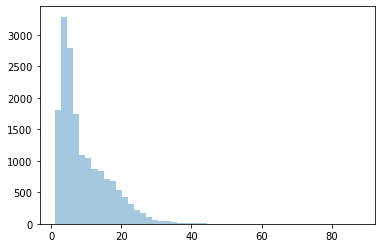

In [213]:
sns.distplot(df_all.groupby(['FIO_MD', 'NHISTORY']).agg({'SUM_UET': 'sum'}), kde=False)

<AxesSubplot:>

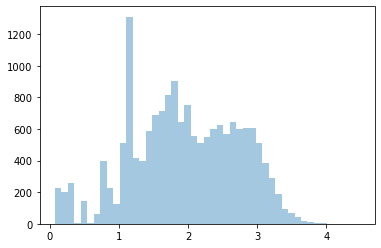

In [214]:
sns.distplot(np.log(df_all.groupby(['FIO_MD', 'NHISTORY']).agg({'SUM_UET': 'sum'})), kde=False)

In [215]:
# Объединим все в итоговую таблицу, в качестве базы возьмем уникальных врачей из исходных данных

In [216]:
df_result = df_all.groupby('FIO_MD').agg({'NHISTORY': 'nunique'}).rename(columns={'NHISTORY': 'tap_count'})
df_result = df_result \
                .merge(priem_by_doc, how='left', left_index=True, right_index=True) \
                .merge(filling_by_doc, how='left', left_index=True, right_index=True) \
                .merge(devit_by_doc, how='left', left_index=True, right_index=True) \
                .merge(top_diag_by_doc, how='left', left_index=True, right_index=True) \
                .merge(avg_rub_by_doc, how='left', left_index=True, right_index=True) \
                .fillna(0) \
                .astype(int) \
                .merge(avg_uet_by_doc, how='left', left_index=True, right_index=True) \
                .drop(columns='tap_count') \
                .reset_index() \
                .merge(avg_uet_rub[['FIO_MD', 'RPU']], on='FIO_MD') \
                .rename(columns={'FIO_MD': 'Врач', 'preim': 'Приемов', 'filling': 'Пломб', 'devit': 'Мышьяков'})

In [217]:
df_result_by_month = df_all \
                        .groupby(['FIO_MD', 'OT_PER_U']) \
                        .agg({'NHISTORY': 'nunique'}) \
                        .rename(columns={'NHISTORY': 'tap_count'}) \
                        .merge(priem_by_doc_month, how='left', left_index=True, right_index=True) \
                        .merge(filling_by_doc_month, how='left', left_index=True, right_index=True) \
                        .merge(devit_by_doc_month, how='left', left_index=True, right_index=True) \
                        .merge(top_diag_by_doc_month, how='left', left_index=True, right_index=True) \
                        .merge(avg_rub_by_doc_month, how='left', left_index=True, right_index=True) \
                        .fillna(0) \
                        .astype(int) \
                        .merge(avg_uet_by_doc_month, how='left', left_index=True, right_index=True) \
                        .drop(columns='tap_count') \
                        .reset_index() \
                        .merge(avg_uet_rub_month[['FIO_MD', 'OT_PER_U', 'RPU']], on=['FIO_MD', 'OT_PER_U']) \
                        .rename(columns={'FIO_MD': 'Врач', 'preim': 'Приемов', 'filling': 'Пломб', 
                                         'devit': 'Мышьяков', 'OT_PER_U': 'Месяц'})                        

In [218]:
# FPV - filling per visit - отношение числа пломб к числу приемов
# DPV - devitalization per vizit - отношение числа мышьяков к числу приемов

df_result['FPV'] = df_result['Пломб'] / df_result['Приемов']
df_result['DPV'] = df_result['Мышьяков'] / df_result['Приемов']
df_result['DPV %'] = df_result['DPV'] * 100

In [219]:
df_result

,Врач,Приемов,Пломб,Мышьяков,K02.1,K02.8,K04.0,K04.5,K05.1,K05.3,K10.2,Z01.2,avg_rub,avg_uet,RPU,FPV,DPV,DPV %
0,Александрова Светлана Викторовна,564,570,5,229,81,102,89,4,2,0,25,1882,10.96,171.7,1.010638,0.008865,0.886525
1,Арутюнян Арутюн Левонович,865,0,0,7,1,26,303,2,87,77,0,791,4.49,176.1,0.000000,0.000000,0.000000
2,Власова Альфия Лябибовна,600,452,11,169,45,122,90,7,101,1,31,2064,12.21,169.1,0.753333,0.018333,1.833333
3,Володин Павел Юрьевич,502,679,67,163,43,127,82,3,26,0,39,2563,14.56,176.0,1.352590,0.133466,13.346614
4,Володько Валентина Ивановна,1007,0,0,6,3,26,577,1,141,102,0,892,4.94,180.4,0.000000,0.000000,0.000000
5,Гвоздева Татьяна Анатольевна,431,431,24,131,43,125,84,0,10,0,22,2005,11.50,174.4,1.000000,0.055684,5.568445
6,Горбикова Эльфия Рашитовна,531,429,22,179,83,129,80,1,9,0,11,1918,11.89,161.3,0.807910,0.041431,4.143126
7,Завгородный Сергей Валерианович,862,0,0,0,0,7,628,1,131,8,0,921,5.05,182.4,0.000000,0.000000,0.000000
8,Захаров Иван Владимирович,472,366,14,144,48,111,77,2,15,0,49,1895,11.48,165.0,0.775424,0.029661,2.966102
9,Камынова Наталия Валериевна,468,478,34,156,60,121,63,9,22,0,22,2211,12.80,172.7,1.021368,0.072650,7.264957


In [220]:
# Метрики мо месяцам
# FPV - filling per visit - отношение числа пломб к числу приемов
# DPV - devitalization per vizit - отношение числа мышьяков к числу приемов

df_result_by_month['FPV'] = df_result_by_month['Пломб'] / df_result_by_month['Приемов']
df_result_by_month['DPV'] = df_result_by_month['Мышьяков'] / df_result_by_month['Приемов']
df_result_by_month['DPV %'] = df_result_by_month['DPV'] * 100

In [221]:
df_result_by_month

,Врач,Месяц,Приемов,Пломб,Мышьяков,K02.1,K02.8,K04.0,K04.5,K05.1,K05.3,K10.2,Z01.2,avg_rub,avg_uet,RPU,FPV,DPV,DPV %
0,Александрова Светлана Викторовна,0122,119,125,1,58,17,14,17,0,2,0,7,1930,11.56,167.0,1.050420,0.008403,0.840336
1,Александрова Светлана Викторовна,0222,124,153,0,52,13,21,29,0,0,0,0,2102,11.33,185.6,1.233871,0.000000,0.000000
2,Александрова Светлана Викторовна,0322,173,153,1,64,27,34,26,2,0,0,10,1799,10.71,168.0,0.884393,0.005780,0.578035
3,Александрова Светлана Викторовна,0422,86,80,0,29,18,18,10,2,0,0,5,1856,11.28,164.5,0.930233,0.000000,0.000000
4,Александрова Светлана Викторовна,0522,62,59,3,26,6,15,7,0,0,0,3,1615,9.32,173.3,0.951613,0.048387,4.838710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Чичикина Галина Павловна,0122,167,0,0,0,0,14,100,0,21,8,0,852,4.68,182.0,0.000000,0.000000,0.000000
130,Чичикина Галина Павловна,0222,254,0,0,0,0,9,159,0,37,10,0,849,4.64,182.7,0.000000,0.000000,0.000000
131,Чичикина Галина Павловна,0322,286,0,0,4,0,19,176,0,39,15,0,849,4.64,183.0,0.000000,0.000000,0.000000
132,Чичикина Галина Павловна,0422,185,0,0,1,0,10,117,0,26,9,0,796,4.38,181.7,0.000000,0.000000,0.000000


In [222]:
df_result.to_excel(f'Лечение_{year}.xlsx', index=False)
df_result_by_month.to_excel(f'Лечение_по_месяцам_{year}.xlsx', index=False)

In [223]:
diag_by_doc.groupby('MKB1', as_index=False) \
    .agg({'diag_count': 'sum'}) \
    .sort_values('diag_count', ascending=False) \
    .head(10)

,MKB1,diag_count
30,K04.5,5139
21,K02.1,3189
28,K04.0,2740
36,K05.3,1409
23,K02.8,1082
96,Z01.2,580
54,K10.2,461
34,K05.1,376
25,K03.6,248
18,K01.0,197


In [224]:
# Число пломб на приеме по врачу (средний FPV за год)

px.bar(df_result.query('(FPV > 0) & (Врач != "Коваленко Ольга Эдуардовна физио")').sort_values('FPV', ascending=False), 
       x='Врач',
       y='FPV',
       title=f"Число пломб на приеме в {year} году")

In [225]:
# Сделать grayscale

greys = n_colors('rgb(100, 100, 100)', 'rgb(255, 255, 255)', len(df_result_by_month['Месяц'].unique())+1, colortype='rgb')

In [226]:
# Средний FPV по месяцам и врачу (ч/б)

px.bar(df_result_by_month.query('(FPV > 0) & (Врач != "Коваленко Ольга Эдуардовна физио")'), 
       x='Врач',
       y='FPV',
       color='Месяц',
       barmode='group',
       color_discrete_sequence=greys,
       title=f"Число пломб на приеме в {year} году").update_xaxes(categoryorder='total descending') \
    .update_layout(plot_bgcolor='rgb(255,255,255)') \
    .update_yaxes(gridcolor='grey')

In [227]:
# Средний FPV по месяцам и врачу (цвет)

px.bar(df_result_by_month.query('(FPV > 0) & (Врач != "Коваленко Ольга Эдуардовна физио")'), 
       x='Врач',
       y='FPV',
       color='Месяц',
       barmode='group',
       title=f"Число пломб на приеме в {year} году").update_xaxes(categoryorder='total descending')

In [228]:
# Средний DPV за год по врачу

px.bar(df_result.query('DPV > 0').sort_values('DPV', ascending=False), 
       x='Врач',
       y='DPV %',
       title=f"Процент приемов с мышьяком в {year} году")

In [229]:
# DPV по месяцу и врачу (ч/б)

px.bar(df_result_by_month.query('DPV > 0'), 
       x='Врач',
       y='DPV %',
       color='Месяц',
       barmode='group',
       color_discrete_sequence=greys,
       title=f"Процент приемов с мышьяком в {year} году").update_xaxes(categoryorder='total descending') \
    .update_layout(plot_bgcolor='rgb(255,255,255)') \
    .update_yaxes(gridcolor='grey')

In [230]:
# DPV по месяцу и врачу (цвет)

px.bar(df_result_by_month.query('DPV > 0'), 
       x='Врач',
       y='DPV %',
       color='Месяц',
       barmode='group',
       title=f"Процент приемов с мышьяком в {year} году").update_xaxes(categoryorder='total descending')

In [231]:
# Средняя стоимость ТАП в руб по врачу

px.bar(df_result.sort_values('avg_rub', ascending=False), 
       x='Врач',
       y='avg_rub',
       title=f'Средняя стоимость ТАП в руб. за {year} году') \
    .update_yaxes(title_text = 'Руб')

In [232]:
# Средняя стоимость ТАП в руб по врачу и месяцу (ч/б), вертикальные бары

px.bar(df_result_by_month, 
       x='Врач',
       y='avg_rub',
       color='Месяц',
       barmode='group',
       width=1060,
       color_discrete_sequence=greys,
       title=f'Средняя стоимость ТАП в руб. за {year} году') \
    .update_layout(plot_bgcolor='rgb(255,255,255)') \
    .update_yaxes(title_text = 'Руб', gridcolor='grey') \
    .update_xaxes(categoryorder='total descending')

In [233]:
# Средняя стоимость ТАП в руб по врачу и месяцу (цв), горизонтальные бары

px.bar(df_result_by_month, 
       y='Врач',
       x='avg_rub',
       color='Месяц',
       barmode='group',
#        width=1060,
       height = 2000,
       orientation = 'h',
       title=f'Средняя стоимость ТАП в руб. за {year} году') \
    .update_yaxes(title_text = 'Руб', categoryorder='total ascending') 

In [234]:
# Средняя стоимость ТАП в УЕТ по врачу

px.bar(df_result.sort_values('avg_uet', ascending=False), 
       x='Врач',
       y='avg_uet',
       title=f'Средняя стоимость ТАП в УЕТ за {year} год') \
    .update_yaxes(title_text = 'УЕТ')

In [235]:
# Средняя стоимость ТАП в УЕТ по врачу и месяцу (ч/б)

px.bar(df_result_by_month, 
       x='Врач',
       y='avg_uet',
       color='Месяц',
       barmode='group',
       width=1660,
       color_discrete_sequence=greys,
       title=f'Среднее количество УЕТ в ТАП за {year} год') \
    .update_layout(plot_bgcolor='rgb(255,255,255)') \
    .update_yaxes(title_text = 'УЕТ', gridcolor='grey') \
    .update_xaxes(categoryorder='total descending')

In [238]:
# Средняя стоимость ТАП в УЕТ по врачу и месяцу (цв)

px.bar(df_result_by_month, 
       x='Врач',
       y='avg_uet',
       color='Месяц',
       barmode='group',
       width=1660,
       title=f'Среднее количество УЕТ в ТАП за {year} год') \
    .update_yaxes(title_text = 'УЕТ') \
    .update_xaxes(categoryorder='total descending')

In [239]:
# Средняя стоимость 1 УЕТ в руб по врачу

px.bar(df_result.query('Врач != "Коваленко Ольга Эдуардовна физио"').sort_values('RPU', ascending=False), 
                x='Врач',
                y='RPU',
                title=f'Средняя стоимость 1 УЕТ в руб за {year} год (план: {mean_uet})',
                text='RPU',
                width=1360) \
    .update_traces(textfont_size=20, textposition="outside", textangle=-45, cliponaxis=False) \
    .update_layout(plot_bgcolor='rgb(255,255,255)')
# fig.show(renderer="notebook_connected")

In [240]:
# Средняя стоимость 1 УЕТ в руб по врачу и месяцу (ч/б)

px.bar(df_result_by_month.query('Врач != "Коваленко Ольга Эдуардовна физио"'), 
                x='Врач',
                y='RPU',
                title=f'Средняя стоимость 1 УЕТ в руб за {year} год (план: {mean_uet})',
                text='RPU',
                color='Месяц',
                barmode='group',
                color_discrete_sequence=greys,
                width=1360) \
    .update_layout(plot_bgcolor='rgb(255,255,255)') \
    .update_yaxes(gridcolor='grey', dtick = 167.7) \
    .update_xaxes(categoryorder='total descending') \
#     .update_traces(textfont_size=20, textposition="outside", textangle=-45, cliponaxis=False) \
# fig.show(renderer="notebook_connected")

In [241]:
# Средняя стоимость 1 УЕТ в руб по врачу и месяцу (цв)

px.bar(df_result_by_month.query('Врач != "Коваленко Ольга Эдуардовна физио"'), 
                x='Врач',
                y='RPU',
                title=f'Средняя стоимость 1 УЕТ в руб за {year} год (план: {mean_uet})',
                text='RPU',
                color='Месяц',
                barmode='group',
                width=1360) \
    .update_yaxes(gridcolor='black', dtick = 167.7) \
    .update_xaxes(categoryorder='total descending')

In [ ]:
# Ниже work in progress

In [ ]:
# Число рабочих дней по врачам с указанием специальности

working_days = df_all.groupby(['FIO_MD', 'PRVS', 'DATE_IN'], as_index=False) \
                        .agg({'NHISTORY': 'nunique', 'SUM_UET': 'sum', 'SUM_RUB': 'sum'}) \
                        .groupby('FIO_MD') \
                        .agg({'PRVS': 'min', 'DATE_IN': 'count', 'SUM_UET': 'sum', 'SUM_RUB': 'sum', 'NHISTORY': 'mean'})
working_days['spec'] = working_days \
                            .PRVS \
                            .map({208: 'тер', 72: 'хир', 69: 'тер', 71: 'тер', 87: 'физио'})
working_days.drop(columns='PRVS', inplace=True)

In [ ]:
working_days.SUM_RUB.sum()

In [ ]:
working_days.SUM_UET.sum()

In [ ]:
working_days

In [ ]:
# Среднедневная выработка УЕТ по специальностям

working_days.groupby('spec').agg({'SUM_UET': 'mean'})

In [ ]:
# Статистика по талонам в день

working_days.query('spec == "тер"').NHISTORY.describe()

In [ ]:
# Число рабочих дней в год по специальности (факт)
# План по терапевтам 4047 (19 врачей Скалкович+Кукушкина пока принимают условно по 0.5 приема) по средней в 213 дней)
# План по терапевтам 3990 (19 врачей Скалкович+Кукушкина пока принимают условно по 0.5 приема) по медиане 210 дней)
# План по хирургам 1314 (6 врачей по 219 дней - среднее по факту 2021 года при медиане 223)

working_days.groupby('spec').agg({'DATE_IN': 'sum'})

In [ ]:
# Статистика по числу рабочих дней

working_days.query('spec == "тер"').DATE_IN.describe()

In [ ]:
# Медианное число рабочих дней терапевтов в 2021 (факт) - Медианное число рабочих дней терапевтов в 2022

ter_days = 210 - working_days.query('spec == "тер"').DATE_IN.median()
ter_days

In [ ]:
# Медианное число рабочих дней хирургов в 2021 (факт) - Медианное число рабочих дней хирургов в 2022
# Чистая медиана 223
# Среднее без Саркисова 219

hir_days = 219 - working_days.query('spec == "хир"').DATE_IN.median()
hir_days

In [ ]:
# Плановые расчеты ниже возможно не завершены (основной расчет был в ноутбуке за 2021 год)

# План на 2022 год

plan2022_oms = 414548
plan2022_total = 414548*100/88
plan2022_total

In [ ]:
# План по специальностям на 2022 год

ter_plan = plan2022_total*78.8/100
hir_plan = plan2022_total*17.9/100
fizio_plan = plan2022_total*3.3/100

In [ ]:
# Число врачей по специальностям
ter_count = 19
hir_count = 6

In [ ]:
# План на 2022 год без января

plan2022_corr = plan2022_total - working_days.SUM_UET.sum()

In [ ]:
# План по специальностям на 2022 год без января

ter_plan_corr = plan2022_corr*78.8/100
hir_plan_corr = plan2022_corr*17.9/100
fizio_plan_corr = plan2022_corr*3.3/100

In [ ]:
ter_plan_corr/ter_count/ter_days

In [ ]:
hir_plan_corr/hir_count/hir_days

In [ ]:
fizio_plan_corr/1/253

In [ ]:
# 

plan2022_total/12 - working_days.SUM_UET.sum()

In [ ]:
# Число рабочих дней по врачам с указанием специальности

working_days = df_all.groupby(['FIO_MD', 'PRVS', 'DATE_IN'], as_index=False) \
                        .agg({'NHISTORY': 'nunique', 'SUM_UET': 'sum'}) \
                        .groupby('FIO_MD') \
                        .agg({'PRVS': 'min', 'DATE_IN': 'count', 'SUM_UET': 'mean', 'NHISTORY': 'mean'})
working_days['spec'] = working_days \
                            .PRVS \
                            .map({208: 'тер', 72: 'хир', 69: 'тер', 71: 'тер', 87: 'физио'})
working_days.drop(columns='PRVS', inplace=True)

In [ ]:
df_all['FIO_MD'].unique()

In [ ]:
# Выполнение УЕТ по дням и количество врачей по специальностям в этот день

uet_by_day = df_all \
                .groupby(['DATE_IN', 'spec'], as_index=False) \
                .agg({'FIO_MD': 'nunique'}) \
                .pivot(index='DATE_IN', columns='spec', values='FIO_MD') \
                .fillna(0) \
                .astype('int32') \
                .merge(df_all \
                        .groupby('DATE_IN') \
                        .agg({'SUM_UET': 'sum'}),
                       on='DATE_IN',
                       how='left'
                      )

In [ ]:
uet_by_day[uet_by_day.index.dayofweek < 5]

In [ ]:
# Среднее УЕТ в день

plt.figure(figsize=(15,10))
sns.lineplot(data=uet_by_day[uet_by_day.index.dayofweek < 5], 
             x='DATE_IN', 
             y=uet_by_day[uet_by_day.index.dayofweek < 5].SUM_UET,
             label='УЕТ')
sns.lineplot(data=uet_by_day[uet_by_day.index.dayofweek < 5], 
             x='DATE_IN', 
             y=(uet_by_day[uet_by_day.index.dayofweek < 5].тер)*100,
             label='Число терапевтов')
sns.lineplot(data=uet_by_day[uet_by_day.index.dayofweek < 5], 
             x='DATE_IN', 
             y=(uet_by_day[uet_by_day.index.dayofweek < 5].хир)*100,
             label='Число хирургов')

In [ ]:
uet_by_day[uet_by_day.index.dayofweek < 5].corr()

In [ ]:
uet_by_day[uet_by_day.index.dayofweek < 5].corr(method='spearman')

In [ ]:
uet_by_day[uet_by_day.index.dayofweek < 5].corr(method='kendall')